Code was developed together with Agajan Torayev and Tobias Elvermann.

In [18]:
import datetime
now = datetime.datetime.now()

# Recurrent Convolutional Neural Networks

## Summer School JGU Mainz — Advanced Methods in Behavioral Economics, 2021

### Carina I. Hausladen

In [19]:
print(now.strftime("%Y-%m-%d"))

2021-09-29


In [20]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [21]:
from __future__ import print_function

import warnings

warnings.simplefilter("ignore")

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
%matplotlib inline

import nltk
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm_notebook

tqdm_notebook().pandas()

import bokeh.plotting as bp
from bokeh.models import HoverTool
from bokeh.plotting import show, output_notebook, reset_output
from bokeh.models.sources import ColumnDataSource

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer

0it [00:00, ?it/s]

In [22]:
nltk.download('wordnet');

[nltk_data] Downloading package wordnet to /Users/carinah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data
Data and research idea are provided by [Prof. Dr. Martin Fochmann, FU Berlin](https://www.wiwiss.fu-berlin.de/fachbereich/bwl/pruefungs-steuerlehre/fochmann/Team/Prof_-Dr_-Fochmann/index.html) <br>
Data includes tax reports from German companies listed in the STOXX Europe 600. <br>

y: hand-coded <br>
X: if the keywords tax\* and/or risk\* were found, 15 words before and after the keyword were extracted and entered as a separate row.


## Recurrent Convolutional Neural Networks
[Lai et al. (2015)](https://www.aaai.org/ocs/index.php/AAAI/AAAI15/paper/viewFile/9745/9552) <br>
RCNN improve upon RecursiveNN, RecurrentNN, and CNNs.

### Recursive Neural Network
[Socher et al. (2013)](https://aclanthology.org/D13-1170.pdf).
- RecursiveNN capture the semantics of a sentence via a tree structure.
- Advantage: Efficient in constructing sentence representations.
- Disadvantages
   - Time complexity is high: at least $O(n^2)$, where $n$ is the length of the text.
   - RecursiveNN are unsuitable for modeling long sentences or documents.

### Recurrent Neural Network
- Analyzes a text word by word and stores the semantics of all the previous text in a hidden layer ([Elman 1990](https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog1402_1)). 
- Advantage: Captures contextual information.  
- Disadvantages
    - Later words are more dominant than earlier words (bias!). 
    - Weak in capturing the semantics of a whole document (because key components could appear anywhere in a document rather than at the end).
- A recurrent cell can be viewed as multiple feedforward cells which propagate their output through time steps:

<img src="figures/recurrent_cell.png" alt="mlp" width="500"/>

### Convolutional Neural Network
- Unbiased model
- Determines discriminative phrases in a text with a max-pooling layer. 
- Advantages
    - Better captures the semantic of texts as compared RecursiveNN or RecurrentNN.
    - Time complexity is $O(n)$. 
- Disadvantage
    - It is difficult to determine the window size.
    - Small windows may result in the loss of some critical information.
    - Large windows result in an enormous parameter space (which could be difficult to train). 

Can we learn more contextual information than conventional window-based neural networks and represent the semantic of texts more precisely?

### RCNN

In [ ]:
- Bi-directional recurrent structure
    - Introduces less noise compared to a traditional window-based neural network.
    - Captures the contextual information when learning word representations. 
    - Reserves a larger range of the word ordering when learning representations of texts. 
- The max-pooling layer automatically judges which features play key roles in text classification.
- Time complexity is $O(n)$

### Read Data

In [23]:
train_df = pd.read_csv('data/tax_risk_train.csv')
test_df = pd.read_csv('data/tax_risk_test.csv')

In [24]:
def get_train_test_data(y_i):
    tok = Tokenizer(num_words=max_features, split=' ')
    tok.fit_on_texts(train_df['x_sentences'].values)
    X_train = tok.texts_to_sequences(train_df['x_sentences'].values)
    Y_train = pd.get_dummies(train_df[y_i]).values

    X_test = tok.texts_to_sequences(test_df['x_sentences'].values)
    Y_test = pd.get_dummies(test_df[y_i]).values

    X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
    return X_train, Y_train, X_test, Y_test

### Build Model
🤓: Understand and change the parameters for generating your RCNN.

In [25]:
# Embedding
max_features = 1000
maxlen = 500
embedding_size = 64

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 1

In [26]:
def build_RCNN_model(print_summary=True):
    model = Sequential(name="RCNN")
    model.add(Embedding(max_features, embedding_size,
                        input_length=maxlen))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    if print_summary:
        print(model.summary())
    return model

#just for illustration purpose
_ = build_RCNN_model()

Model: "RCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 64)           64000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 496, 64)           20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 142       
_________________________________________________________________
activation_4 (Activation)    (None, 2)                 0      

In [27]:
def train_and_evaluate_RCNN_model(model, X_train, Y_train, X_test, Y_test):
    print('Train...')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs)

    loss, acc = model.evaluate(X_train, Y_train, batch_size=batch_size)
    print("Evaluate training set.")
    print("Loss on train set: ", loss)
    print("Accuracy on train set: ", acc)

    loss, acc = model.evaluate(X_test, Y_test, batch_size=batch_size)
    print("Evaluate test set.")
    print("Score on test set: ", loss)
    print("Accuracy on test set: ", acc)
    Y_pred = model.predict(X_test)
    return np.argmax(Y_pred, axis=1)

### Get performance metrics

In [28]:
results = {}
for y in ["y1", "y2", "y3"]:
    results[y] = {}
    X_train, y_train, X_test, y_test = get_train_test_data(y)
    model = build_RCNN_model(print_summary=False)
    y_pred = train_and_evaluate_RCNN_model(model, X_train, y_train, X_test, y_test)
    y_test = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)
    results[y]["RCNN"] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f-score": f1, "confusion_matrix": cm}

Train...
563/563 [==============================] - 8s 14ms/step - loss: 0.2876 - accuracy: 0.8946
Evaluate training set.
Loss on train set:  0.2876289486885071
Accuracy on train set:  0.8945622444152832
209/209 [==============================] - 3s 16ms/step - loss: 0.3258 - accuracy: 0.8657
Evaluate test set.
Score on test set:  0.3258230686187744
Accuracy on test set:  0.8656549453735352
Train...
563/563 [==============================] - 9s 15ms/step - loss: 0.1859 - accuracy: 0.9330
Evaluate training set.
Loss on train set:  0.18591880798339844
Accuracy on train set:  0.9330055713653564
209/209 [==============================] - 4s 19ms/step - loss: 0.2021 - accuracy: 0.9256
Evaluate test set.
Score on test set:  0.20207154750823975
Accuracy on test set:  0.9255591034889221
Train...
563/563 [==============================] - 9s 15ms/step - loss: 0.1087 - accuracy: 0.9629
Evaluate training set.
Loss on train set:  0.10872223973274231
Accuracy on train set:  0.9629190564155579
209/2

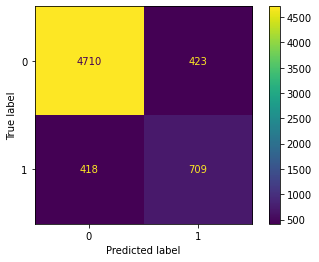

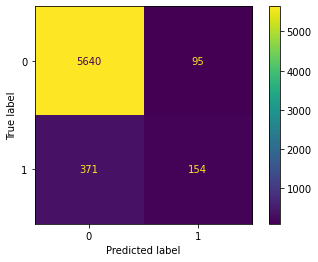

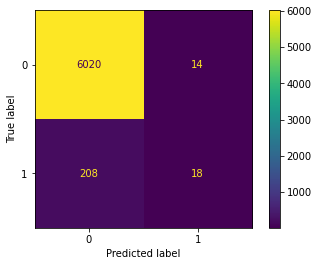

In [29]:
for y in ["y1", "y2"]:
    ConfusionMatrixDisplay(results[y]["RCNN"]["confusion_matrix"]).plot()

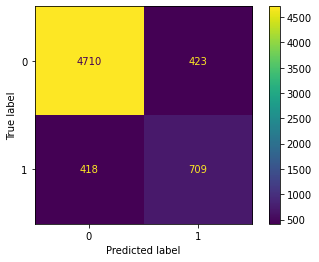

In [30]:
ConfusionMatrixDisplay(results["y3"]["RCNN"]["confusion_matrix"]).plot()

## Comparison to shallow classifiers from session 2

In [31]:
import pickle
with open('data/session2_results.pickle', 'rb') as handle:
    s2_results = pickle.load(handle)

In [32]:
for y in ["y1", "y2", "y3"]:
    del results[y]["RCNN"]["confusion_matrix"]
    results[y] = s2_results[y] | results[y] # joining dictionaries this way is only possible in py>3.9

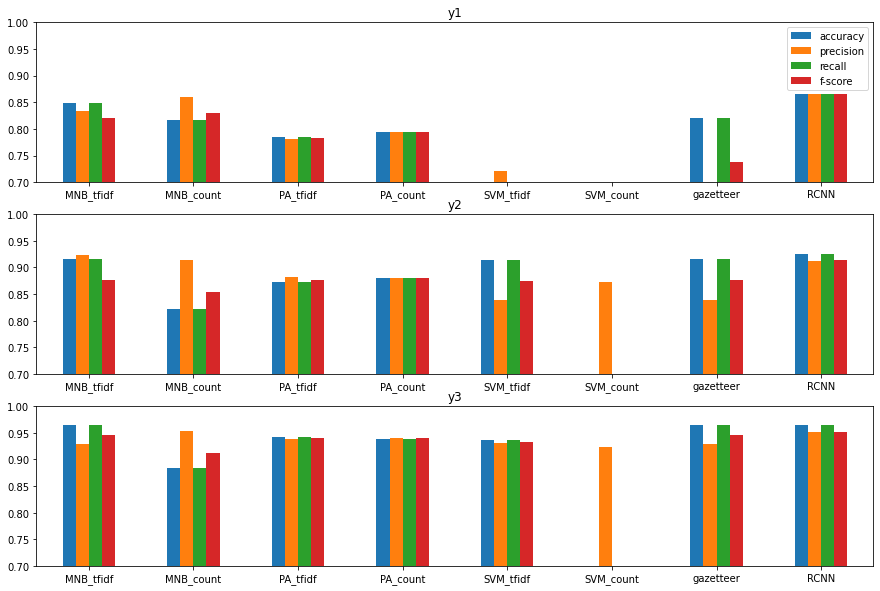

In [33]:
plot_args = {"rot": 0, "figsize":(15, 10), "ylim": (0.7, 1)}
fig, axes = plt.subplots(nrows=3, ncols=1)
pd.DataFrame(results["y1"]).T.plot.bar(ax=axes[0], title="y1", **plot_args)
pd.DataFrame(results["y2"]).T.plot.bar(ax=axes[1], title="y2", legend=False, **plot_args)
pd.DataFrame(results["y3"]).T.plot.bar(ax=axes[2], title="y3", legend=False, **plot_args);

# It's your turn! 🧑‍💻 ~10'